In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
from typing import Union
import pandas as pd
from joblib import Parallel, delayed

import seaborn as sns
import matplotlib.pyplot as plt

if 'src' in os.getcwd():
    os.chdir('..')

from utils.create_data_examples import DatasetPreprocessor, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)


dataset = Dataset('german')

preprocessor = DatasetPreprocessor(dataset, one_hot=True, random_state=SEED)

X_train, X_test, y_train, y_test = preprocessor.get_numpy()

print(f'Shapes: X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}')

Shapes: X_train: (800, 61), X_test: (200, 61), y_train: (800,), y_test: (200,)


In [2]:
class MLPClassifier(nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 output_dim: int, 
                 hidden_dims: list = [64, 64, 64],
                 activation: str = 'relu',
                 dropout: float = 0.0
        ) -> None:
        '''
        input_dim: int, input dimension
        output_dim: int, output dimension
        hidden_dims: list, hidden layer dimensions
        activation: str, activation function
        dropout: float, dropout rate
        '''
        super(MLPClassifier, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dims = hidden_dims
        self.activation = activation
        self.dropout = dropout
        self.layers = nn.ModuleList()
        self.build_model()

    def build_model(self):
        input_dim = self.input_dim
        for hidden_dim in self.hidden_dims:
            self.layers.append(nn.Linear(input_dim, hidden_dim))
            if self.activation == 'relu':
                self.layers.append(nn.ReLU())
            elif self.activation == 'tanh':
                self.layers.append(nn.Tanh())
            elif self.activation == 'sigmoid':
                self.layers.append(nn.Sigmoid())
            else:
                raise ValueError('Invalid activation function')
            if self.dropout > 0:
                self.layers.append(nn.Dropout(self.dropout))
            input_dim = hidden_dim
        self.layers.append(nn.Linear(input_dim, self.output_dim))
        self.layers.append(nn.Softmax(dim=1))
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def predict_proba(self, x):
        return self.forward(x)
    
    def predict_crisp(self, x):
        return torch.argmax(self.predict_proba(x), dim=1)
    
    def fit(self, 
            X_train: Union[np.array, torch.Tensor],
            y_train: Union[np.array, torch.Tensor],
            X_val: Union[np.array, torch.Tensor] = None,
            y_val: Union[np.array, torch.Tensor] = None,
            epochs: int = 100,
            lr: float = 0.002, 
            batch_size: int = 256,
            verbose: bool = True,
            early_stopping: bool = True,
            device: str = 'cpu'
        ) -> None:
        '''
        '''
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        
        X_train = array_to_tensor(X_train, device=device, dtype=torch.float32)
        y_train = array_to_tensor(y_train, device=device, dtype=torch.long)
        if X_val is not None:
            X_val = array_to_tensor(X_val, device=device, dtype=torch.float32)
            y_val = array_to_tensor(y_val, device=device, dtype=torch.long)
            
            
        for epoch in range(epochs):
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                optimizer.zero_grad()
                y_pred = self.forward(X_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()
                
            
            
            if verbose:
                if epoch % 10 == 0:
                    print(f'Epoch: {epoch}, Loss: {loss.item()}')
            
            if early_stopping:
                if X_val is not None:
                    self.eval()
                    y_pred_val = self.forward(X_val)
                    val_loss = criterion(y_pred_val, y_val)
                    if verbose:
                        if epoch % 10 == 0:
                            print(f'Epoch: {epoch}, Validation Loss: {val_loss.item()}')
                    if val_loss < 0.01:
                        break
                else:
                    if loss < 0.01:
                        break
                    
    def evaluate(self, 
                 X_test: Union[np.array, torch.Tensor],
                 y_test: Union[np.array, torch.Tensor],
                 device: str = 'cpu'
        ) -> float:
        '''
        X_test: np.array | torch.Tensor, test data
        y_test: np.array | torch.Tensor, test labels
        device: str, device to use
        '''
        self.eval()
        X_test = array_to_tensor(X_test, device=device)
        y_test = array_to_tensor(y_test, device=device)
        y_pred = self.predict_crisp(X_test)
        accuracy = (y_pred == y_test).sum().item() / len(y_test)
        recall = recall_score(y_test, y_pred, average='binary')
        precision = precision_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
        
        return accuracy, recall, precision, f1
    
        
    

                    
def array_to_tensor(X: Union[np.array, torch.Tensor], 
                    device: str = 'cpu',
                    dtype: torch.dtype = torch.float32
    ) -> torch.Tensor:
    '''
    X: np.array, array to convert, or torch.Tensor
    device: str, device to use
    dtype: torch.dtype, data type
    '''
    if isinstance(X, np.ndarray):
        X = torch.tensor(X, dtype=dtype)
        
    return X.to(device)
    
        
        

In [3]:
mlp = MLPClassifier(input_dim=X_train.shape[1], output_dim=2, hidden_dims=[16, 16, 16], activation='relu', dropout=0.1)

mlp.fit(
    X_train, 
    y_train, 
    X_val=X_test, 
    y_val=y_test
)

accuracy, recall, precision, f1 = mlp.evaluate(X_test, y_test)

print(f'Accuracy: {accuracy}, Recall: {recall}, Precision: {precision}, F1: {f1}')

Epoch: 0, Loss: 0.6799245476722717
Epoch: 0, Validation Loss: 0.6764631867408752
Epoch: 10, Loss: 0.6169472336769104
Epoch: 10, Validation Loss: 0.6023653149604797
Epoch: 20, Loss: 0.5057129263877869
Epoch: 20, Validation Loss: 0.5671982169151306
Epoch: 30, Loss: 0.436215877532959
Epoch: 30, Validation Loss: 0.5592845678329468
Epoch: 40, Loss: 0.4157538414001465
Epoch: 40, Validation Loss: 0.5574848055839539
Epoch: 50, Loss: 0.41122838854789734
Epoch: 50, Validation Loss: 0.567503809928894
Epoch: 60, Loss: 0.40907761454582214
Epoch: 60, Validation Loss: 0.5761190056800842
Epoch: 70, Loss: 0.4077084958553314
Epoch: 70, Validation Loss: 0.5722090005874634
Epoch: 80, Loss: 0.40736350417137146
Epoch: 80, Validation Loss: 0.5715053081512451
Epoch: 90, Loss: 0.407222718000412
Epoch: 90, Validation Loss: 0.5709624290466309
Accuracy: 0.745, Recall: 0.8714285714285714, Precision: 0.7870967741935484, F1: 0.8271186440677966


In [4]:
def train_K_mlps(X_train, y_train, X_test, y_test, K: int = 5, evaluate: bool = True):
    '''
    X_train: np.array, training data
    y_train: np.array, training labels
    X_test: np.array, test data
    y_test: np.array, test labels
    K: int, number of models to train
    '''
    accuracies = []
    recalls = []
    precisions = []
    f1s = []
    models = []
    for k in range(K):
        layers = np.random.randint(2, 5)
        dims = np.random.choice([16,24,32], size=layers)
        dropout = np.random.randint(0,3) / 10
        mlp = MLPClassifier(input_dim=X_train.shape[1], output_dim=2, hidden_dims=dims, activation='relu', dropout=dropout)
        mlp.fit(
            X_train, 
            y_train, 
            X_val=X_test, 
            y_val=y_test,
            verbose=False,
            early_stopping=False,
            lr=0.01,
            epochs=20
        )
        accuracy, recall, precision, f1 = mlp.evaluate(X_test, y_test)
        accuracies.append(accuracy)
        recalls.append(recall)
        precisions.append(precision)
        f1s.append(f1)
        models.append(mlp)
    return models, accuracies, recalls, precisions, f1s


def train_K_mlps_in_parallel(X_train, y_train, X_test, y_test, K: int = 20, n_jobs: int = 4):
    '''
    X_train: np.array, training data
    y_train: np.array, training labels
    X_test: np.array, test data
    y_test: np.array, test labels
    K: int, number of models to train
    n_jobs: int, number of jobs to run in parallel
    '''
    
    k_for_each_job = K // n_jobs 
    
    results = Parallel(n_jobs=n_jobs)(
        delayed(train_K_mlps)(X_train, y_train, X_test, y_test, k_for_each_job) for _ in range(n_jobs)
    )
    return results

results = train_K_mlps_in_parallel(X_train, y_train, X_test, y_test, K=32, n_jobs=1)

accuracies = [accuracy for _, accuracy, _, _, _ in results]
accuracies = np.array(accuracies).flatten()
print(f'Accuracies: {accuracies}')
models = [model for model, _, _, _, _ in results]
models = [model for sublist in models for model in sublist]
print(f'Number of models: {len(models)}')

Accuracies: [0.735 0.645 0.715 0.725 0.7   0.75  0.735 0.715 0.715 0.695 0.74  0.75
 0.735 0.735 0.735 0.715 0.725 0.74  0.69  0.745 0.735 0.74  0.725 0.745
 0.74  0.705 0.74  0.73  0.71  0.72  0.705 0.69 ]
Number of models: 32


In [5]:
def ensemble_predict_proba(models: list[nn.Module], X: Union[np.ndarray, torch.Tensor]) -> list[float]:
    '''
    models: list, list of trained models
    X: np.array, data
    '''
    predictions = []
    X_tensor = array_to_tensor(X)
    for model in models:
        predictions.append(model.predict_proba(X_tensor).detach().numpy()[:, 1])
    predictions = np.array(predictions)
    return predictions

preds = ensemble_predict_proba(models, X_test)
print(preds.shape)
print(f'Ensemble Predictions: {preds[:, 7]}')

(32, 200)
Ensemble Predictions: [0.27663842 0.89916396 0.07193778 0.07917484 0.5298259  0.8242767
 0.35341233 0.85768974 0.00574979 0.4320035  0.09109139 0.32785928
 0.6056919  0.67688704 0.3365292  0.04825987 0.18757628 0.48718622
 0.02218261 0.15390159 0.382873   0.771418   0.03825848 0.7121813
 0.9534827  0.625686   0.13018432 0.23890717 0.5066166  0.17560977
 0.27092844 0.4068108 ]


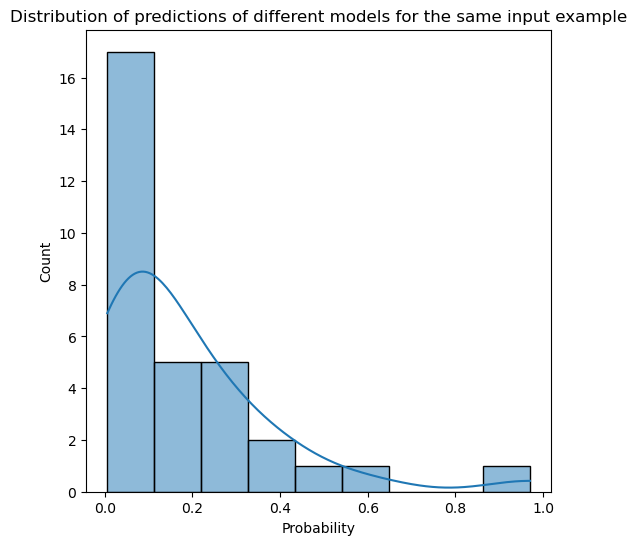

[0.27663842 0.06375884 0.07709865 0.97016555 0.0887951  0.05287223
 0.20612903 0.4475173  0.00584942 0.59665334 0.07487445 0.07787032
 0.05425018 0.07360147 0.01491667 0.04294046 0.057944   0.1763
 0.0084373  0.05913319 0.37579146 0.19260037 0.05591771 0.05379865
 0.1565083  0.22034703 0.15959346 0.23890717 0.3171269  0.03131811
 0.268282   0.4068108 ]


In [6]:
def plot_distribution_of_predictions(predictions: Union[list[float], np.ndarray], save_dir: Union[str, None] = None) -> None:
    
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    if isinstance(predictions, list):
        preds = np.ndarray(predictions, dtype=np.float64)
    else:
        preds = predictions
        
    fig = plt.figure(figsize=(6,6))
    # plt.hist(preds, bins=50, density=True)
    sns.histplot(preds, kde=True)
    
    if save_dir:
        path = os.path.join(save_dir, 'distribution_of_predictions.png')
        plt.savefig(path, dpi=300)
        
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.title('Distribution of predictions of different models for the same input example')
    
    plt.show()
    
    

example_preds = preds[:, 8]
plot_distribution_of_predictions(example_preds, save_dir='images/statrob')
    
print(example_preds)
    

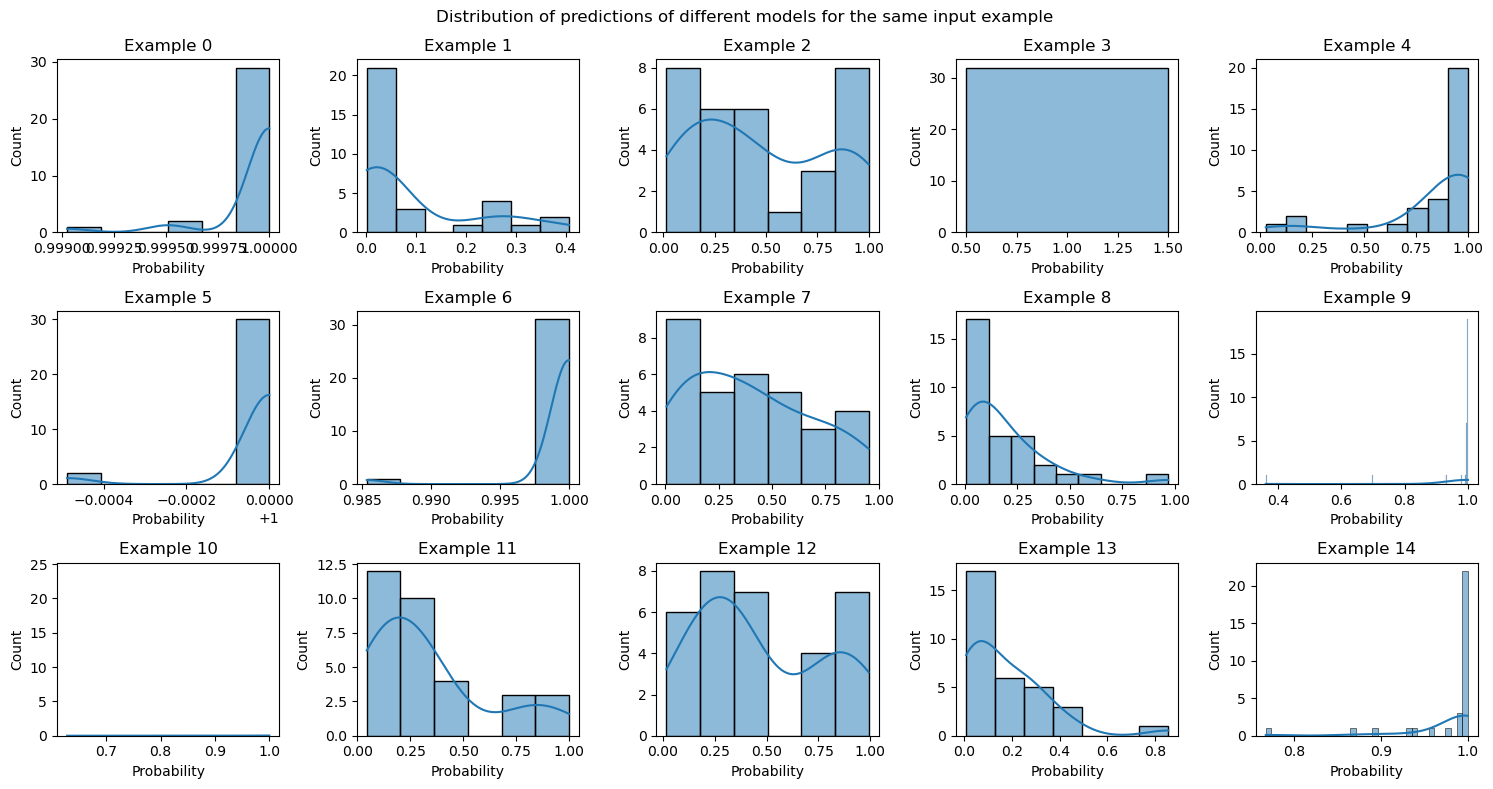

In [7]:
def plot_grid_of_distribution_predictions(predictions: Union[list[list[float]], np.ndarray], 
                                          save_dir: Union[str, None] = None,
                                          rows: int = 3,
                                          cols: int = 5
    ) -> None:
    
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    if isinstance(predictions, list):
        preds = np.ndarray(predictions, dtype=np.float16)
    else:
        preds = predictions.astype(np.float16)
        
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 8))
    axes = axes.flatten()
    
    for i in range(rows * cols):
        
        sns.histplot(preds[:, i], kde=True, ax=axes[i])
        
        # last row
        # if i // cols == rows - 1: 
        axes[i].set_xlabel('Probability')
            
        # if i % cols == 0:
        axes[i].set_ylabel('Count')
        
        axes[i].set_title(f'Example {i}')
        
    plt.suptitle('Distribution of predictions of different models for the same input example')
    plt.tight_layout()
    
    if save_dir:
        path = os.path.join(save_dir, 'grid_of_predictions_distributions.png')
        plt.savefig(path, dpi=300)
        
    plt.show()
    
    
plot_grid_of_distribution_predictions(preds, save_dir='images/statrob')

Sample distribution


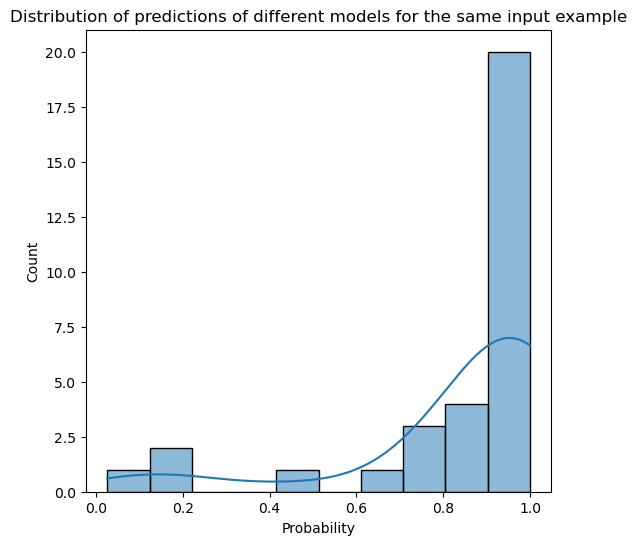

Estimated Beta distribution


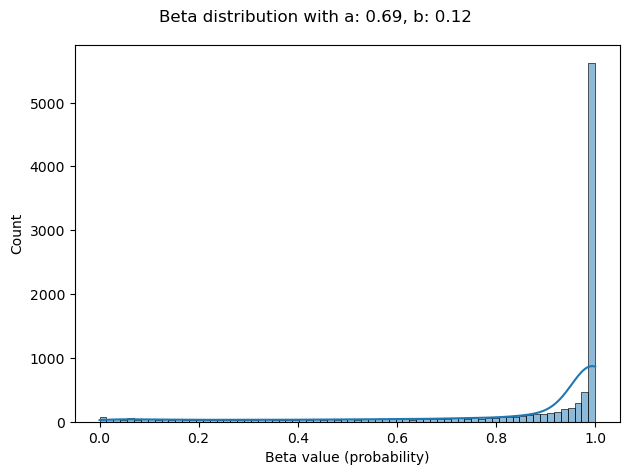

In [8]:
import scipy
import warnings

# Scipy screams some radom stuff
warnings.filterwarnings('ignore', category=RuntimeWarning)

def estimate_beta_distribution(
    sample: np.ndarray,
    method: str = 'MLE',
    ) -> tuple[float, float]:
    '''
    Estimate beta distribution based on a sample
    
    Parameters:
        - sample (np.ndarray): a 1D array of size N
        - method (str): either 'MM' or 'MLE'. This decides the method of parameter estimation.
        
    Returns:
        - (alpha, beta) parameters of the estimated beta distribution 
    ''' 
    
    match method:
        case 'MM': 
            alpha, beta, _, _ = scipy.stats.beta.fit(sample, method='MM')
        case 'MLE':
            alpha, beta, _, _ = scipy.stats.beta.fit(sample, method='MLE')
        case _:
            raise ValueError(f'Estimation method not known: {method} should be either "MM" or "MLE"!')
    
    return alpha, beta

def plot_beta(
    alpha: float,
    beta: float,
    sample_size: int = 10000,
    save_dir: Union[str, None] = None,
    ) -> None:
    
    samples = np.random.beta(alpha, beta, size=sample_size)
    
    
    sns.histplot(samples, kde=True)
    
    plt.suptitle(f'Beta distribution with a: {alpha:.2f}, b: {beta:.2f}')
    plt.xlabel('Beta value (probability)')
    plt.ylabel('Count')
    plt.tight_layout()
    
    plt.show()

        

s = preds[:, 4]
alpha, beta = estimate_beta_distribution(s, method='MLE')

alpha = np.clip(alpha, 0, 100)
beta = np.clip(beta, 0, 100)


print('Sample distribution')
plot_distribution_of_predictions(s)
print('Estimated Beta distribution')
plot_beta(alpha, beta)

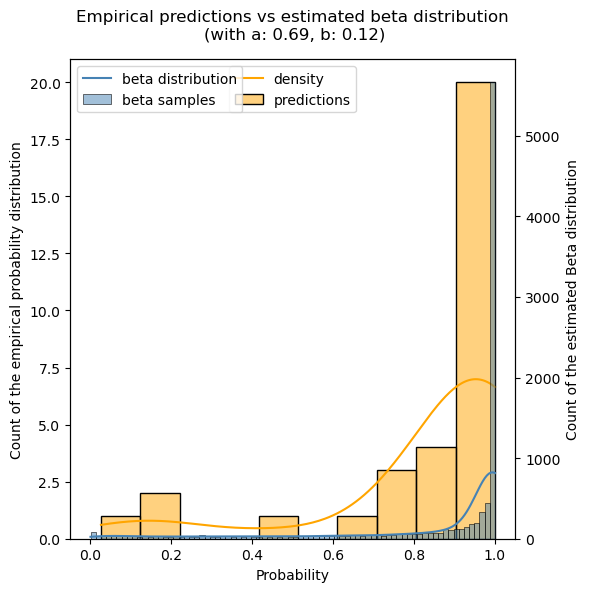

In [9]:
def plot_beta_on_original(preds: np.ndarray, 
        alpha: float,
        beta: float,
        sample_size: int = 10000,
    ) -> None:
        
    fig, ax = plt.subplots(figsize=(6,6))
    # plt.hist(preds, bins=50, density=True)
    sns.histplot(preds, kde=True, ax=ax, color='orange', legend=True)
    
    plt.legend(['density', 'predictions'], loc='upper center')
    
    
    samples = np.random.beta(alpha, beta, size=sample_size)
    
    ax2 = ax.twinx()
    sns.histplot(samples, kde=True, ax=ax2, color='steelblue', legend=True)
    plt.legend(['beta distribution', 'beta samples'])
    
    
    plt.suptitle(f'Empirical predictions vs estimated beta distribution \n(with a: {alpha:.2f}, b: {beta:.2f})')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Count of the empirical probability distribution')
    ax2.set_ylabel('Count of the estimated Beta distribution')
    plt.tight_layout()
    
    plt.show()
    
plot_beta_on_original(s, alpha, beta)

In [10]:
scipy.stats.beta.interval(.90, alpha, beta)

(0.1743993759793217, 0.9999999999875582)

In [11]:
def bootstrap(sample: np.ndarray, bootstrap_sample_size: int = 20, buckets: int = 30):
    return np.random.choice(sample, size=(buckets, bootstrap_sample_size), replace=True)

def test_with_CI(sample: np.ndarray, confidence: float = 0.9, thresh: float = 0.5) -> bool:
    alpha, beta = estimate_beta_distribution(sample, method='MLE')
    left, right = scipy.stats.beta.interval(confidence, alpha, beta)
    return left > thresh


s_bstrapped = bootstrap(s)
binary_test_results = []
for _s in s_bstrapped:
    res = test_with_CI(_s) 
    binary_test_results.append(res)
binary_test_results = np.array(binary_test_results, dtype=int)
# Binom
n = len(binary_test_results)
successes = binary_test_results.sum() 
p =  successes / n
print(f'p: {p:.2f}, n: {n}')

scipy.stats.binomtest(successes, n, p=0.5, alternative='greater')

p: 0.30, n: 30


BinomTestResult(k=9, n=30, alternative='greater', statistic=0.3, pvalue=0.991937599144876)

***
### Comment 1
The issue:    

    The issue we face here is that essentially by bootstrapping we can synthetically boost the significance of the test and hack p-value. Let's say thah I perform bootstrap on K=32 classifiers' outputs and sample 30 buckets and define our binomial test as H_0: p = 0.5, H_1: p > 0.5. So, the input to the binom test is, e.g., successes=18, n=30 -> which results with p-value = 0.18. But, when I do the same ratio of succcesses to losses, but increase the number of boostrapped buckets we arrive at crazy low p-values. E.g., successes=90 n=120 -> p-value = 0.009.

Question:
1. How to adjust the number of buckets bootstrapped for the sake of the binomial test?

### Comment 2
The issue:   

    Interpretation of the significance of our testing scheme is not so obvious.   
    
    [1] The first part uses Beta distribution to check if the classification threshold is inside the confidence interval of the median value (median inferred from Beta). Now, the confidence interval has some confidence associated with it -- let's call this confidence tenatively A.  

    The second part performs bootstrap on the empirical destribution and estimates the distribution of Beta distributions. In each estimated Beta distribution we perform the CI verification from [1] with confidence level A. Now, we treat the results of this verification as binary variable (contains / doesn't contain), and this way we arrive at a Binomial distribution. Then, we perform the binomial test (or Z/T/other test) and here we input the number of successes and number of buckets. We also need to define some reference value for the null hypothesis p_0, as well as confidence level B.
    
Questions:  
1. How do we interpret p_0? 
1. How to select proper confidence levels for A and B?
1. What is the interplay between A and B? 


***

In [38]:
from src.explainers.growingspheres import growing_spheres_search

def test_gs(sample: np.ndarray, pred_fn_crisp: callable, preprocessor: DatasetPreprocessor) -> bool:
    
    sample = sample.reshape(1, -1)
    
    _input = pd.DataFrame(sample, columns=preprocessor.X_train.columns)
    
    cf = growing_spheres_search(
        instance=_input,
        keys_mutable=preprocessor.X_train.columns.tolist(),
        keys_immutable=[],
        continuous_cols=preprocessor.continuous_columns,
        binary_cols=preprocessor.encoder.get_feature_names_out().tolist(),
        feature_order=preprocessor.X_train.columns.tolist(),
        pred_fn_crisp=pred_fn_crisp,
    )
    
    print(cf)

    
    
def wrap_ensemble_crisp(sample: np.ndarray, models: list[nn.Module], method='avg-std') -> float:
    '''
    Wrap the ensemble prediction function to be used in the test_gs function.  
    Specifically, reduce the ensemble predictions to a single value.
    
    Parameters:
        sample: np.ndarray, input example
        models: list[nn.Module], list of trained models
        method: str, method to use for reducing the ensemble predictions, either 'avg-std' or 'avg'
                the first one uses the average minus the standard deviation, the second one uses only the average
    
    Returns:
        float: reduced value
    '''
    pred_fn = lambda x: ensemble_predict_proba(models, x)
    match method:
        case 'avg-std':
            return ((pred_fn(sample).mean(axis=0) - pred_fn(sample).std(axis=0)) > 0.5).astype(int)
        case 'avg':
            return (pred_fn(sample).mean(axis=0) > 0.5).astype(int)
        case _:
            raise ValueError(f'Unknown method: {method}')

pred_function_crisp = lambda x: wrap_ensemble_crisp(x, models, method='avg-std')
test_gs(X_test[5], pred_function_crisp, preprocessor)

[ 0.0830428   0.06034449  0.57393175  0.7310178   0.30036437  0.39551642
 -0.01793236  1.          1.          1.          0.          0.
  0.          1.          0.          1.          1.          0.
  1.          0.          0.          0.          0.          1.
  0.          0.          1.          0.          0.          1.
  0.          1.          0.          0.          0.          1.
  0.          0.          0.          0.          1.          0.
  1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          1.          1.
  0.          0.          0.          1.          1.          0.
  1.        ]
